In [1]:
import pandas as pd

import numpy as np
import itertools
import category_encoders as ce

from numpy import mean
from numpy import std
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import precision_score, recall_score, auc
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import shapiro, normaltest
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [4]:
#df = pd.read_csv('bank updated.csv')              Old .csv with numeric pdays.

df = pd.read_csv('bank updated categories.csv')

col_names = ['age', 
             'job', 
             'martial', 
             'education', 
             'cred_in_default', 
             'balance',
             'housing',
             'loan',
             'contact',
             'last_contact_day',
             'last_contact_month',
             'last_contact_dur',
             'num_of_contacts_during_campaign',
             'past_days',
             'prev_contacts',
             'prev_outcome',
             'sub_term_deposit']
df.columns = col_names
df.head()

,age,job,martial,education,cred_in_default,balance,housing,loan,contact,last_contact_day,last_contact_month,last_contact_dur,num_of_contacts_during_campaign,past_days,prev_contacts,prev_outcome,sub_term_deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,No Contact,0,unknown,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,No Contact,0,unknown,no
2,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,No Contact,0,unknown,no
3,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,No Contact,0,unknown,no
4,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,No Contact,0,unknown,no


In [5]:
##Prep for MLP
print("Bank data set dimensions : {}".format(df.shape))

Bank data set dimensions : (4521, 17)


In [6]:
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
df = pd.read_csv('bank updated categories.csv')

# Define features and target
X = df[['age', 'job', 'marital', 'education', 'balance', 'housing',
        'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome']]
y = df['y'] 

# Define the columns to encode
cols_to_encode = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'pdays', 'poutcome']

# Filter cols_to_encode to include only those present in X
cols_to_encode = [col for col in cols_to_encode if col in X.columns]

# Extract column indices for encoding
col_indices = [X.columns.get_loc(col) for col in cols_to_encode]

# Create the encoder
encoder = OrdinalEncoder()
X_enc = X.copy()  # Make a copy of X
X_enc[cols_to_encode] = encoder.fit_transform(X[cols_to_encode])

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, stratify=y, random_state=3)


print("y_test set dimensions : {}".format(y_test.shape))

# Define the MLPClassifier
mlp = MLPClassifier(
    max_iter=200,
    alpha=0.1,
    activation='logistic',
    solver='adam')

# Fit the model to the training data
mlp.fit(X_enc, y)
mlp_predict = mlp.predict(X_enc)

y_test set dimensions : (1357,)


In [35]:
###Part B question B 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a range of number of neurons (k) and number of iterations
neurons_range = range(1, 26)  # From 1 to 25 neurons
iterations_range = [100, 200, 300, 400, 500] # Specify a range of iterations to test

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': [(k,) for k in neurons_range],  # Single hidden layer with k neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Best parameters:", best_params)
print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
print("Best iteration:", best_iter)

Classification Report:
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      1201
         yes       0.79      0.07      0.13       156

    accuracy                           0.89      1357
   macro avg       0.84      0.53      0.54      1357
weighted avg       0.88      0.89      0.85      1357

Best parameters: {'hidden_layer_sizes': (3,), 'max_iter': 400}
Best accuracy: 88.62%
Best iteration: 400


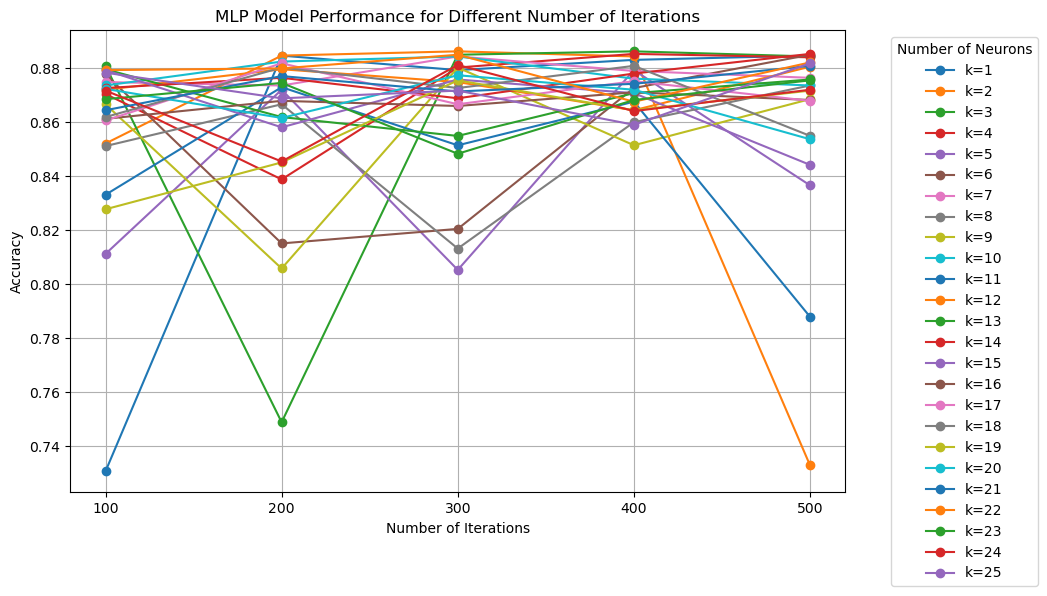

In [36]:
####Part B question B -  Plotting the accuracy for each number of iterations
results = grid_search.cv_results_
mean_test_scores = np.array([results['mean_test_score'][i::len(iterations_range)] for i in range(len(iterations_range))])

plt.figure(figsize=(10, 6))
for i, k in enumerate(neurons_range):
    plt.plot(iterations_range, mean_test_scores[:, i], marker='o', label=f'k={k}')

plt.title('MLP Model Performance for Different Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.xticks(iterations_range)
plt.legend(title='Number of Neurons', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

IndexError: index 24 is out of bounds for axis 0 with size 24

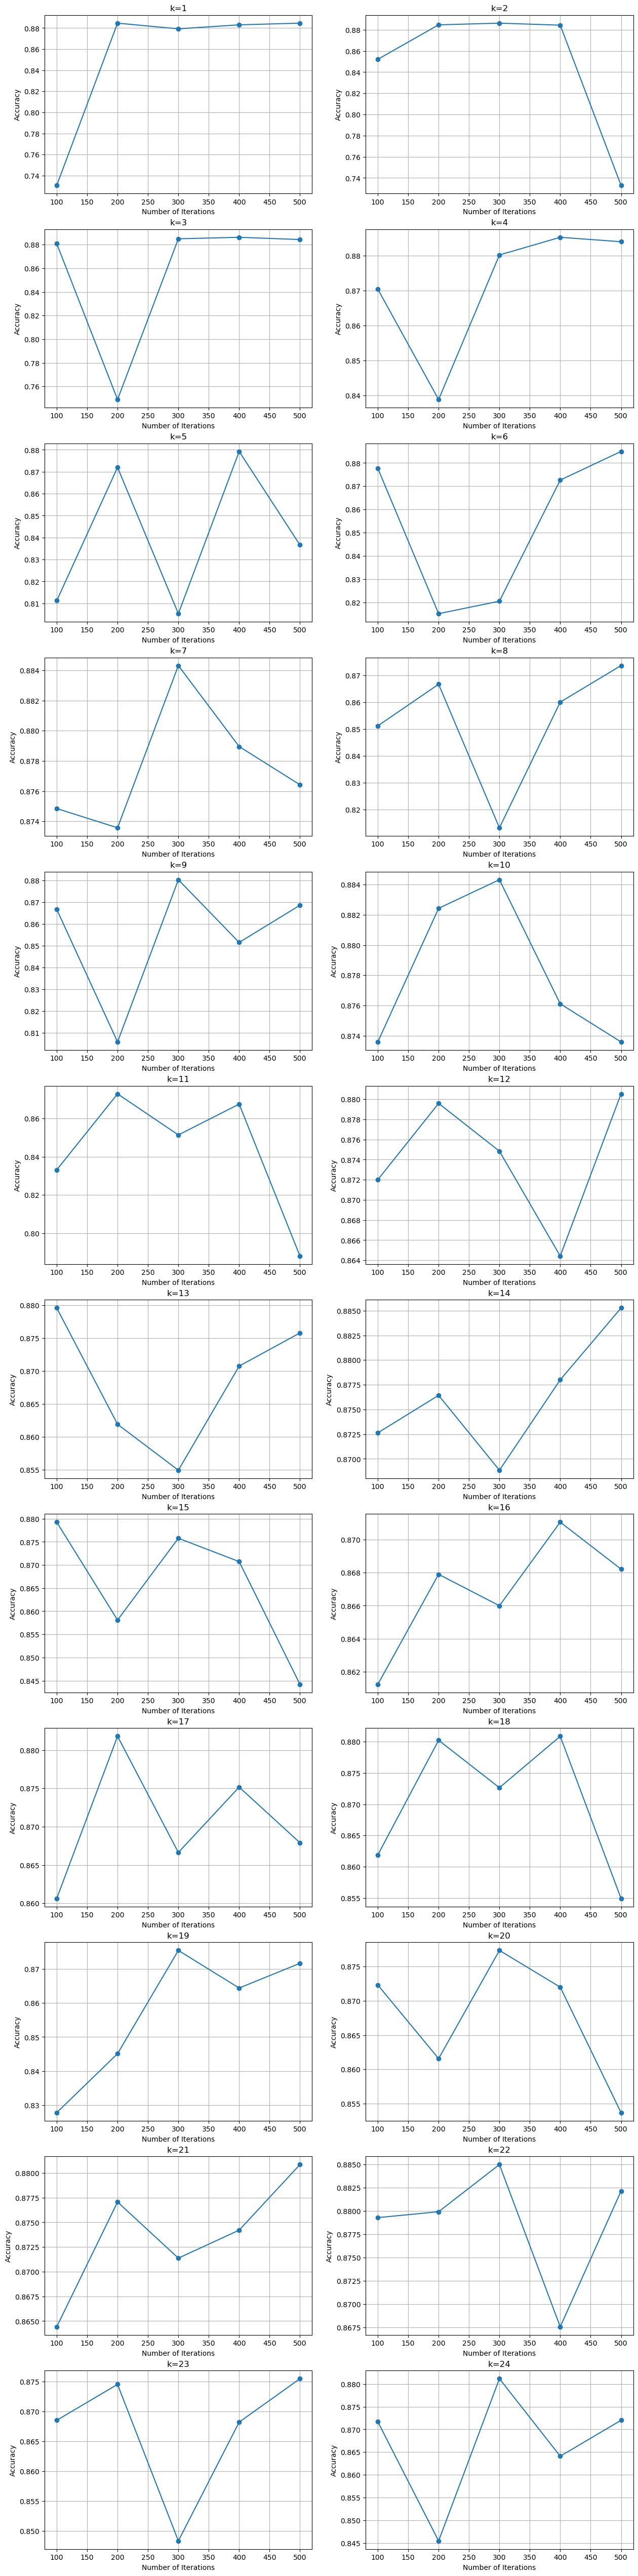

In [37]:
import matplotlib.pyplot as plt

# Assuming you already have results, iterations_range, and neurons_range defined

# Calculate the number of rows and columns for the grid
rows = 12
cols = int(len(neurons_range) / rows)

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 65))  # Adjust figsize as needed

# Iterate through neurons and plot on corresponding subplot
for i, k in enumerate(neurons_range):
    ax = axes.flat[i]  # Get the current subplot
    ax.plot(iterations_range, mean_test_scores[:, i], marker='o', label=f'k={k}')
    ax.set_title(f'k={k}')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Accuracy')
    ax.grid(True)

# Adjust layout and add common labels
fig.suptitle('MLP Model Performance for Different Number of Neurons')
fig.tight_layout()  # Adjust spacing between subplots

plt.show()


Iteration 1, loss = 4.60546051
Iteration 2, loss = 2.71785661
Iteration 3, loss = 1.54384308
Iteration 4, loss = 0.89932424
Iteration 5, loss = 1.10289092
Iteration 6, loss = 1.19747756
Iteration 7, loss = 0.75190545
Iteration 8, loss = 0.58491004
Iteration 9, loss = 0.63085388
Iteration 10, loss = 0.65159780
Iteration 11, loss = 0.44189961
Iteration 12, loss = 0.42542286
Iteration 13, loss = 0.83425553
Iteration 14, loss = 1.03531400
Iteration 15, loss = 1.13466489
Iteration 16, loss = 0.71118913
Iteration 17, loss = 0.50688126
Iteration 18, loss = 0.53836544
Iteration 19, loss = 0.40436421
Iteration 20, loss = 0.46893313
Iteration 21, loss = 0.41281296
Iteration 22, loss = 0.37497452
Iteration 23, loss = 0.45019065
Iteration 24, loss = 0.47680734
Iteration 25, loss = 0.37772332
Iteration 26, loss = 0.36285842
Iteration 27, loss = 0.46459064
Iteration 28, loss = 0.65508342
Iteration 29, loss = 0.54842931
Iteration 30, loss = 0.46113599
Iteration 31, loss = 0.59028247
Iteration 32, los

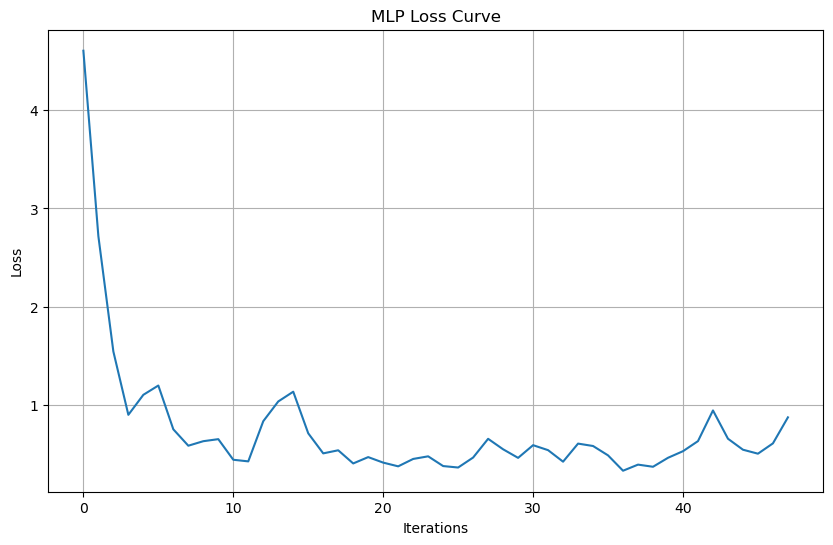

In [39]:
##Question C Part B
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Create an MLPClassifier instance with default parameter values and verbose set to True
mlp = MLPClassifier(verbose=True)

# Fit the model to the training data
mlp.fit(X_train, y_train)

# Predict using the testing set
mlp_predict = mlp.predict(X_test)

# Calculate MLP Accuracy
mlp_accuracy = accuracy_score(y_test, mlp_predict)

# MLP Classification report
mlp_classification_report = classification_report(y_test, mlp_predict)

# MLP Training set score
mlp_training_score = mlp.score(X_train, y_train)

# MLP Testing set score
mlp_testing_score = mlp.score(X_test, y_test)

# Print MLP Accuracy, Classification report, Training set score, and Testing set score as percentages
#print("MLP Accuracy: {:.2f}%".format(mlp_accuracy * 100))
#print("\nMLP Classification Report:\n", mlp_classification_report)
#print("\nMLP Training set score: {:.2f}%".format(mlp_training_score * 100))
#print("MLP Testing set score: {:.2f}%".format(mlp_testing_score * 100))

# Plotting the loss curve
loss_values = mlp.loss_curve_
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.title('MLP Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

###This is after performing a basic MLP this is not looking for iterations and k<25 neurons - code from Lab
from sklearn.metrics import accuracy_score, classification_report

# Fit the model to the training data
mlp.fit(X_train, y_train)

# Predict using the testing set
mlp_predict = mlp.predict(X_test)

# Calculate MLP Accuracy
mlp_accuracy = accuracy_score(y_test, mlp_predict)

# MLP Classification report
mlp_classification_report = classification_report(y_test, mlp_predict)

# MLP Training set score
mlp_training_score = mlp.score(X_train, y_train)

# MLP Testing set score
mlp_testing_score = mlp.score(X_test, y_test)

# Print MLP Accuracy, Classification report, Training set score, and Testing set score as percentages
print("MLP Accuracy: {:.2f}%".format(mlp_accuracy * 100))
print("\nMLP Classification Report:\n", mlp_classification_report)
print("\nMLP Training set score: {:.2f}%".format(mlp_training_score * 100))
print("MLP Testing set score: {:.2f}%".format(mlp_testing_score * 100))

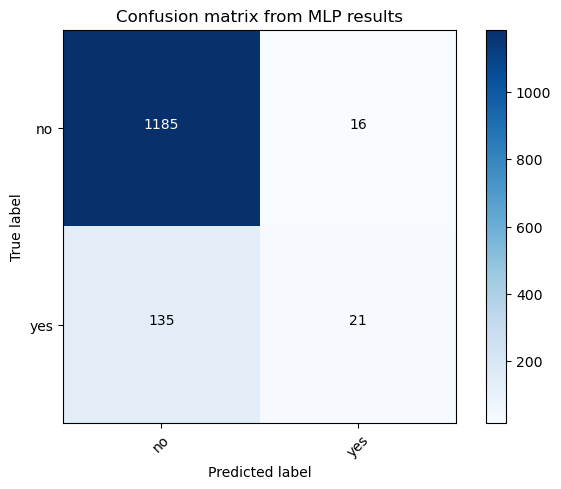

In [9]:
# Function to generate confusion matrix plot
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, mlp_predict)
class_names = ['no', 'yes']  # Replace with your actual class names

# Plot non-normalized confusion matrix
plt.figure()
generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix from MLP results')
plt.show()